# Reinforcement Learning: An Introduction; Richard S. Sutton and Andrew G. Barto

## Policy Iteration

### The goal of RL is to find the optimal policy for a given environment. The dynamic programming (DP), a model-based method can be used to orgnise and structure the search for a good policy using the value function

### Computing the value function directly is computationally expensive, hence, we find the value function iteratively






In [2]:
## Mout your google drive
from google.colab import drive
## mount location
drive.mount('/content/drive')

Mounted at /content/drive


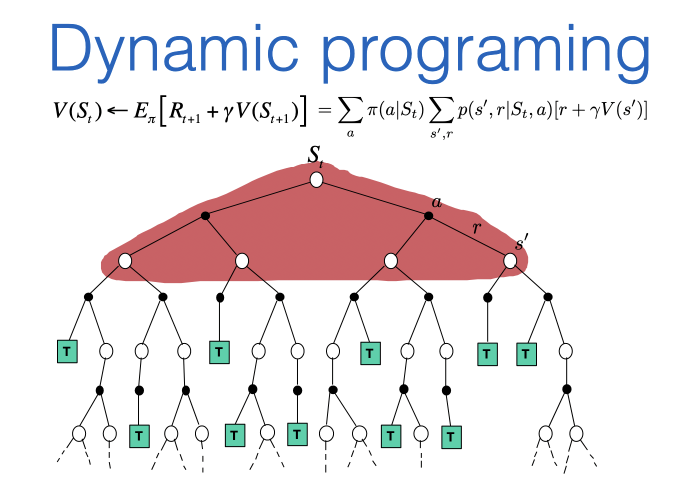

In [7]:
## https://web.stanford.edu/class/cme241/lecture_slides/rich_sutton_slides/11-12-TD.pdf
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread("/content/drive/MyDrive/rl/dp.png", cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (img.shape[1] // 2, img.shape[0] // 2), cv2.INTER_CUBIC)
cv2_imshow(img)

### the bellman equation defines the value function as:

### $V_{\pi}(s) = \sum_{a \in A} \pi(a|s)[\sum_{s', r} P(s', r| s, a)[R_s^a+\gamma V_{\pi}(s')]]$

### this can be converted into an iterative form as follows;
### $v_{k+1} = \sum_{a \in A} \pi(a|s) [\sum_{s', r} P(s', r| s, a)[R_s^a+\gamma v_{k}(s')]]$
### The idea is as $k → \infty$ $v_{k}$ converges to the exact value function $V_{\pi}$ the value function of the policy
### this step of policy iteration is called the policy evaluation
### A stopping condition for this iterative algorithm can be defined as; $\Delta = max(|v - V(s)|) < threshold$ where $v$ is the old value of state s and $V(s)$ is the new value of state s

### Algorithm for the policy evaluation step
### Algorithm:
### Input $\pi$ the policy to be evaluated
### Initialise $V(s)$ for all states $s \in S^+$
### Repeat
### &emsp;&emsp; $\Delta = 0$
### &emsp;&emsp; for each $s \in S$
### &emsp;&emsp;&emsp;&emsp; $v = V(s)$
### &emsp;&emsp;&emsp;&emsp; $V_{\pi}(s) = \sum_{a \in A} \pi(a|s)[\sum_{s', r} P(s', r| s, a)[R_s^a+\gamma V_{\pi}(s')]]$
### &emsp;&emsp;&emsp;&emsp; $\Delta = max(|v - V(s)|)$
### until $\Delta < threshold$
### Output $V \approx V_{\pi}$

### After approximating the $V_{\pi}$, for an arbitrary policy $\pi$, next step is to improve the policy
### The qustion to as here is for a given state s, is choosing an action $a \neq \pi(s)$ is better or worst,
### to answer this, consider the q value; q value is defined as taking an action a at state s and following the policy $\pi$

### $q_{\pi}(s,a) = \sum_{s', r} P(s', r| s, a)[R_{s}^a+\gamma V_{\pi}(s')]$

### the criterian to improve the policy is to check if the $q(s, a) > \pi$ where $a \sim \pi'(.|s)$, then taking the action a and following the policy $\pi$ is better than, just following the policy $\pi$

### hence, $\pi'(s) > \pi(s)$

### To find this policy, we take the $\pi'(s) = argmax_{a}q_{\pi}(s,a) = v_{\pi^*}$

### The policy improvment algorithm as follows;

### policy stable = $true$
### for each $s \in S$
### &emsp;&emsp; $a = \pi(s)$
### &emsp;&emsp; $\pi(s) = argmax_{a}q_{\pi}(s,a)$
### &emsp;&emsp; if $a \neq \pi(s)$; then policy stable = $false$

### If policy stable, return $V$ and $\pi$ else take the new policy to policy evaluation

In [1]:
# Solving the FrozenLake problem with policy iteration: https:/​/​gym.​openai.​com/​envs/FrozenLake-​v0/
## https://github.com/shirsho-12/RL/blob/main/DP/frozen_lake_policy_iteration.py
import torch
import gym

### Play episodes given a policy

In [2]:
def run_episode(env, policy):
    state = env.reset()
    total_reward = 0
    is_done = False
    while not is_done:
        action = policy[state].item()
        state, reward, is_done, info = env.step(action)
        total_reward += reward
    return total_reward

### Policy evaluation step

In [3]:
def policy_evaluation(env, policy, gamma, threshold):
    num_states = env.observation_space.n
    V = torch.zeros(num_states)
    max_delta = threshold + 1
    while max_delta > threshold:
        temp = torch.zeros(num_states)
        for state in range(num_states):
            action = policy[state].item()
            for proba, new_state, reward, _ in env.env.P[state][action]:
                temp[state] += proba * (reward + V[new_state] * gamma)
        max_delta = torch.max(torch.abs(V - temp))
        V = temp.clone()
    return V

### Policy Improvement step

In [4]:
def policy_improvement(env, V, gamma):
    num_states, num_actions = env.observation_space.n, env.action_space.n
    policy = torch.zeros(num_states)
    for state in range(num_states):
        actions = torch.zeros(num_actions)
        for action in range(num_actions):
            for proba, new_state, reward, _ in env.env.P[state][action]:
                actions[action] += proba * (reward + V[new_state] * gamma)
        policy[state] = torch.argmax(actions)
    return policy

### Policy iteration

In [5]:
def policy_iteration(env, gamma=0.99, threshold=0.0001):
    num_states, num_actions = env.observation_space.n, env.action_space.n
    policy = torch.randint(high=num_actions, size=(num_states,)).float()
    while True:
        V = policy_evaluation(env, policy, gamma=gamma, threshold=threshold)
        new_policy = policy_improvement(env, V, gamma=gamma)
        if torch.equal(new_policy, policy):
            return V, new_policy
        policy = new_policy.clone()

In [6]:
if __name__ == "__main__":
    NUM_EPISODES = 1000
    env = gym.make("FrozenLake-v0") 
    # env = gym.make("FrozenLake8x8-v0")
    num_states = env.observation_space.n
    num_actions = env.action_space.n
    print(num_states, num_actions)
    V_optimal, optimal_policy = policy_iteration(env)
    print("Optimal values:\n",  V_optimal)
    print("Optimal policy", optimal_policy)

    total_reward = []
    for n in range(NUM_EPISODES):
        total_reward.append(run_episode(env, optimal_policy))
    print(f"Success rate over {NUM_EPISODES} episodes: {sum(total_reward) * 100 / NUM_EPISODES}%")

16 4
Optimal values:
 tensor([0.5404, 0.4966, 0.4681, 0.4541, 0.5569, 0.0000, 0.3572, 0.0000, 0.5905,
        0.6421, 0.6144, 0.0000, 0.0000, 0.7410, 0.8625, 0.0000])
Optimal policy tensor([0., 3., 3., 3., 0., 0., 0., 0., 3., 1., 0., 0., 0., 2., 1., 0.])
Success rate over 1000 episodes: 71.8%
